In [184]:
import random 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import math
import os

############## Zシンドロームの測定が先、Xシンドロームの測定が後(反復符号の論理エラーの関係を調整)

#エラーの定義 qubitは三次元配列で1つ目のインデックスでXかZか、2,3個目のインデックスで位置を指定
def x_error(qubit,i,j):
    qubit[0][i][j] = (qubit[0][i][j]+1)%2
def y_error(qubit,i,j):
    qubit[0][i][j] = (qubit[0][i][j]+1)%2    
    qubit[1][i][j] = (qubit[1][i][j]+1)%2
def z_error(qubit,i,j):
    qubit[1][i][j] =  (qubit[1][i][j]+1)%2 

def single_biased(qubit,i,j,p): # etaはバイアス
    p_x = p 
    p_z = p 
    prob = random.random() 
    if prob < p_z: #Z error
        z_error(qubit,i,j)
    elif prob < p_z+p_x: # X error
        x_error(qubit,i,j)
    elif prob < p_z+2*p_x: # Y error
        y_error(qubit,i,j)

def reversed_single_biased(qubit,i,j,p): # 表面符号と反復符号で逆になっているエラー
    p_x = p 
    p_z = p 
    prob = random.random() 
    if prob < p_z: #Z error
        x_error(qubit,i,j)
    elif prob < p_z+p_x: # X error
        z_error(qubit,i,j)
    elif prob < p_z+2*p_x: # Y error
        y_error(qubit,i,j)

def bitflip_error(qubit,i,j,p): # etaはバイアス
    p_x = p 
    p_z = p 
    prob = random.random() 
    if prob < 2*p_x: #Z error
        x_error(qubit,i,j)

def p_x_error(qubit,i,j,p):
    prob = random.random() 
    if prob < p:
        x_error(qubit,i,j)

def p_z_error(qubit,i,j,p):
    prob = random.random() 
    if prob < p:
        z_error(qubit,i,j)

# i番目にHadamard gateを作用させる
def H(qubit,i,j):
    qubit[0][i][j] = (qubit[0][i][j] + qubit[1][i][j]) % 2
    qubit[1][i][j] = (qubit[1][i][j] + qubit[0][i][j]) % 2
    qubit[0][i][j] = (qubit[0][i][j] + qubit[1][i][j]) % 2

#i番目がcontrolビット j 番目がtargetビットのCNOTgate
def CNOT(qubit_c,i,j,qubit_t,k,l):     #c, tには二次元[][]を代入する
    qubit_t[0][k][l] = (qubit_t[0][k][l] + qubit_c[0][i][j])%2 #コントロール側のXエラーはターゲットに
    qubit_c[1][i][j] = (qubit_c[1][i][j] + qubit_t[1][k][l])%2 #ターゲット側のZエラーはコントロールに

def rotated_surface_code(code_distance,p_list,rep):

    qubits_d = np.zeros((2,code_distance,code_distance)) #データ量子ビットの格納
    qubits_d_X = np.zeros((rep+2,code_distance,code_distance)) #全体でのXエラーの履歴
    qubits_d_Z = np.zeros((rep+2,code_distance,code_distance)) #全体でのXエラーの履歴
    qubits_m_in = np.zeros((2,code_distance-1,code_distance-1)) #測定量子ビット(中)の数
    qubits_m_out_X = np.zeros((2,2,int((code_distance-1)/2))) #測定量子ビット(外)の数
    qubits_m_out_Z = np.zeros((2,2,int((code_distance-1)/2))) #測定量子ビット(外)の数

    syndrome_in_X = np.zeros((rep+2, code_distance-1, code_distance-1)) #シンドローム測定の回数+最初の状態のシンドローム+最後の測定から計算したシンドローム
    syndrome_in_Z = np.zeros((rep+2, code_distance-1, code_distance-1)) #最初、最後のシンドローム測定、最後のデータの測定のみ
    syndrome_out_X = np.zeros((rep+2,2,int((code_distance-1)/2)))
    syndrome_out_Z = np.zeros((rep+2,2,int((code_distance-1)/2)))

    #############  ループ部分  ##################

    for num in range(rep):
        
        ######################### 準備 ###########################
        ### 反復符号でのエラー
        for i in range(code_distance):
            for j in range(code_distance):
                p_x_error(qubits_d,i,j,p_list[0])
                p_z_error(qubits_d,i,j,p_list[1])
        
        ### アンシラにエラー
        #内側
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                # Xシンドローム
                if (i+j) % 2 == 0:
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    H(qubits_m_in,i,j)
                    p_z_error(qubits_m_in,i,j,p_list[7])
                # Zシンドローム
                if (i+j) % 2 == 1:
                    p_x_error(qubits_m_in,i,j,p_list[6])
        # 外側
        # Xシンドローム
        for j in range(int((code_distance-1)/2)):
            p_x_error(qubits_m_out_X,0,j,p_list[6])
            H(qubits_m_out_X,0,j)
            p_z_error(qubits_m_out_X,0,j,p_list[7])
            p_x_error(qubits_m_out_X,1,j,p_list[6])
            H(qubits_m_out_X,1,j)
            p_z_error(qubits_m_out_X,1,j,p_list[7])
        # Zシンドローム
        for i in range(int((code_distance-1)/2)):
            p_x_error(qubits_m_out_X,0,i,p_list[6])
            p_x_error(qubits_m_out_X,1,i,p_list[6])
        ######################### 準備終わり ###########################
        
        ######################### シンドローム測定 ###########################  

        ### Zシンドローム
        for i in range(code_distance-1):
            for j in range(code_distance-1): 
                # 外側(上を初めに)
                if i == 0 and j % 2 == 0:
                    CNOT(qubits_d,i,j,qubits_m_out_Z,0,int(j/2))
                    p_x_error(qubits_d,0,j,p_list[2])
                    p_z_error(qubits_d,0,j,p_list[3])
                    p_x_error(qubits_m_out_Z,0,int(j/2),p_list[4])
                    p_z_error(qubits_m_out_Z,0,int(j/2),p_list[5])
                    CNOT(qubits_d,i,j+1,qubits_m_out_Z,0,int(j/2))
                    p_x_error(qubits_d,0,j+1,p_list[2])
                    p_z_error(qubits_d,0,j+1,p_list[3])
                    p_x_error(qubits_m_out_Z,0,int(j/2),p_list[4])
                    p_z_error(qubits_m_out_Z,0,int(j/2),p_list[5])
                # 内側
                elif (i+j) % 2 == 1: 
                    CNOT(qubits_d,i,j,qubits_m_in,i,j)
                    p_x_error(qubits_d,i,j,p_list[2])
                    p_z_error(qubits_d,i,j,p_list[3])
                    p_x_error(qubits_m_in,i,j,p_list[4])
                    p_z_error(qubits_m_in,i,j,p_list[5])
                    CNOT(qubits_d,i,j+1,qubits_m_in,i,j)
                    p_x_error(qubits_d,i,j+1,p_list[2])
                    p_z_error(qubits_d,i,j+1,p_list[3])
                    p_x_error(qubits_m_in,i,j,p_list[4])
                    p_z_error(qubits_m_in,i,j,p_list[5])
                    CNOT(qubits_d,i+1,j,qubits_m_in,i,j)
                    p_x_error(qubits_d,i+1,j,p_list[2])
                    p_z_error(qubits_d,i+1,j,p_list[3])
                    p_x_error(qubits_m_in,i,j,p_list[4])
                    p_z_error(qubits_m_in,i,j,p_list[5])
                    CNOT(qubits_d,i+1,j+1,qubits_m_in,i,j)
                    p_x_error(qubits_d,i+1,j+1,p_list[2])
                    p_z_error(qubits_d,i+1,j+1,p_list[3])
                    p_x_error(qubits_m_in,i,j,p_list[4])
                    p_z_error(qubits_m_in,i,j,p_list[5])
        # 外側(下を最後に)
        for j in range(code_distance-1):
            i == code_distance-2
            if j % 2 == 1:
                CNOT(qubits_d,code_distance-1,j,qubits_m_out_Z,1,int((j-1)/2))
                p_x_error(qubits_d,code_distance-1,j,p_list[2])
                p_z_error(qubits_d,code_distance-1,j,p_list[3])
                p_x_error(qubits_m_out_Z,1,int((j-1)/2),p_list[4])
                p_z_error(qubits_m_out_Z,1,int((j-1)/2),p_list[5])
                CNOT(qubits_d,code_distance-1,j+1,qubits_m_out_Z,1,int((j-1)/2))
                p_x_error(qubits_d,code_distance-1,j+1,p_list[2])
                p_z_error(qubits_d,code_distance-1,j+1,p_list[3])
                p_x_error(qubits_m_out_Z,1,int((j-1)/2),p_list[4])
                p_z_error(qubits_m_out_Z,1,int((j-1)/2),p_list[5]) 
        ### Xシンドローム測定(データ量子ビットに生じるZエラーは反復符号に取り込まれる)
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                # 外側(左を最初に)
                if j == 0 and i % 2 == 1:
                    CNOT(qubits_m_out_X,0,int((i-1)/2),qubits_d,i,j)
                    p_x_error(qubits_d,i,j,p_list[6])
                    #p_z_error(qubits_d,i,j,p_list[7])
                    p_x_error(qubits_m_out_X,0,int((i-1)/2),p_list[6])
                    p_z_error(qubits_m_out_X,0,int((i-1)/2),p_list[7])
                    CNOT(qubits_m_out_X,0,int((i-1)/2),qubits_d,i+1,j)
                    p_x_error(qubits_d,i+1,j,p_list[6])
                    #p_z_error(qubits_d,i+1,j,p_list[7])
                    p_x_error(qubits_m_out_X,0,int((i-1)/2),p_list[6])
                    p_z_error(qubits_m_out_X,0,int((i-1)/2),p_list[7])
                # 内側
                elif (i+j) % 2 == 0: 
                    CNOT(qubits_m_in,i,j,qubits_d,i,j)
                    p_x_error(qubits_d,i,j,p_list[6])
                    #p_z_error(qubits_d,i,j,p_list[7])
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    p_z_error(qubits_m_in,i,j,p_list[7])
                    CNOT(qubits_m_in,i,j,qubits_d,i,j+1)
                    p_x_error(qubits_d,i,j+1,p_list[6])
                    #p_z_error(qubits_d,i,j+1,p_list[7])
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    p_z_error(qubits_m_in,i,j,p_list[7])
                    CNOT(qubits_m_in,i,j,qubits_d,i+1,j)
                    p_x_error(qubits_d,i+1,j,p_list[6])
                    #p_z_error(qubits_d,i+1,j,p_list[7])
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    p_z_error(qubits_m_in,i,j,p_list[7])
                    CNOT(qubits_m_in,i,j,qubits_d,i+1,j+1)
                    p_x_error(qubits_d,i+1,j+1,p_list[6])
                    #p_z_error(qubits_d,i+1,j+1,p_list[7])
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    p_z_error(qubits_m_in,i,j,p_list[7])
                # 外側(右を最後に)
                elif j == code_distance-2 and i % 2 == 0:
                    CNOT(qubits_m_out_X,1,int(i/2),qubits_d,i,code_distance-1)
                    p_x_error(qubits_d,i,code_distance-1,p_list[6])
                    #p_z_error(qubits_d,i,code_distance-1,p_list[7])
                    p_x_error(qubits_m_out_X,1,int(i/2),p_list[6])
                    p_z_error(qubits_m_out_X,1,int(i/2),p_list[7])
                    CNOT(qubits_m_out_X,1,int(i/2),qubits_d,i+1,code_distance-1)
                    p_x_error(qubits_d,i+1,code_distance-1,p_list[6])
                    #p_z_error(qubits_d,i+1,code_distance-1,p_list[7])
                    p_x_error(qubits_m_out_X,1,int(i/2),p_list[6])  
                    p_z_error(qubits_m_out_X,1,int(i/2),p_list[7]) 
    
        ######################### シンドローム測定終わり ###########################  

        ######################### エラーの履歴　########################
        for i in range(code_distance):
            for j in range(code_distance):
                qubits_d_X[num+1][i][j] =  qubits_d[0][i][j]
                qubits_d_Z[num+1][i][j] =  qubits_d[1][i][j]
        ######################### エラーの履歴終わり　########################

        ######################### 測定結果の格納 & 初期化　#########################
        ### Zシンドローム ###
        # 内側
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if (i+j) % 2 == 1: 
                    p_x_error(qubits_m_in,i,j,p_list[6]) # 測定エラー
                    syndrome_in_Z[num+1][i][j] =  qubits_m_in[0][i][j] # Xを格納
                    qubits_m_in[0][i][j] = 0
                    qubits_m_in[1][i][j] = 0
        # 外側
        for i in range(int((code_distance-1)/2)):
            p_x_error(qubits_m_in,i,j,p_list[6]) # 測定エラー
            syndrome_out_Z[num+1][0][i] =  qubits_m_out_Z[0][0][i] # 上
            qubits_m_out_Z[0][0][i] = 0
            qubits_m_out_Z[1][0][i] = 0
            p_x_error(qubits_m_in,i,j,p_list[6]) # 測定エラー
            syndrome_out_Z[num+1][1][i] =  qubits_m_out_Z[0][1][i] # 下
            qubits_m_out_Z[0][1][i] = 0
            qubits_m_out_Z[1][1][i] = 0
        
        ### Xシンドローム ###
        # 内側
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if (i+j)%2 == 0: ### Xシンドローム
                    H(qubits_m_in,i,j)
                    p_x_error(qubits_m_in,i,j,p_list[6])
                    p_z_error(qubits_m_in,i,j,p_list[7])
                    p_x_error(qubits_m_in,i,j,p_list[6]) # 測定エラー
                    syndrome_in_X[num+1][i][j] =  qubits_m_in[0][i][j] # Zを格納
                    qubits_m_in[0][i][j] = 0
                    qubits_m_in[1][i][j] = 0
        # 外側
        for i in range(int((code_distance-1)/2)):
            H(qubits_m_out_X,0,i)
            p_x_error(qubits_m_out_X,0,i,p_list[6])
            p_z_error(qubits_m_out_X,0,i,p_list[7]) 
            p_x_error(qubits_m_out_X,0,i,p_list[6]) # 測定エラー
            syndrome_out_X[num+1][0][i] =  qubits_m_out_X[0][0][i] # 左
            qubits_m_out_X[0][0][i] = 0
            qubits_m_out_X[1][0][i] = 0
            H(qubits_m_out_X,1,i)
            p_x_error(qubits_m_out_X,1,i,p_list[6]) 
            p_z_error(qubits_m_out_X,1,i,p_list[7]) 
            p_x_error(qubits_m_out_X,1,i,p_list[6]) # 測定エラー
            syndrome_out_X[num+1][1][i] =  qubits_m_out_X[0][1][i] # 右
            qubits_m_out_X[0][1][i] = 0
            qubits_m_out_X[1][1][i] = 0
        ######################### 測定結果の格納 & 初期化 終わり#########################

    ###################  ループ終了 #################

    ######################### 測定結果からシンドロームを計算する #########################

    ### Zシンドローム
    # 内側
    for i in range(code_distance-1):
        for j in range(code_distance-1):
            if (i+j)%2 == 1: 
                syndrome_in_Z[rep+1][i][j] =  (qubits_d[0][i][j]+qubits_d[0][i][j+1]+qubits_d[0][i+1][j]+qubits_d[0][i+1][j+1]) % 2
    # 外側
    for i in range(int((code_distance-1)/2)):
        # 上
        syndrome_out_Z[rep+1][0][i] = (qubits_d[0][0][2*i]+qubits_d[0][0][2*i+1]) % 2
        # 下
        syndrome_out_Z[rep+1][1][i] = (qubits_d[0][code_distance-1][2*i+1]+qubits_d[0][code_distance-1][2*i+2]) % 2
    ### データ量子ビットをresult_dataに移す
    result_data_X = np.zeros((code_distance, code_distance))
    for i in range(code_distance):
        for j in range(code_distance):
            result_data_X[i][j] = qubits_d[0][i][j]
            qubits_d_X[rep+1][i][j] =  qubits_d[0][i][j]

    ### Xシンドローム
    for i in range(code_distance):
        for j in range(code_distance):
            H(qubits_d,i,j)
    # 内側
    for i in range(code_distance-1):
        for j in range(code_distance-1):
            if (i+j)%2 == 0: 
                syndrome_in_X[rep+1][i][j] =  (qubits_d[0][i][j]+qubits_d[0][i][j+1]+qubits_d[0][i+1][j]+qubits_d[0][i+1][j+1]) % 2
    # 外側
    for i in range(int((code_distance-1)/2)):
        # 右
        syndrome_out_X[rep+1][1][i] = (qubits_d[0][2*i][code_distance-1]+qubits_d[0][2*i+1][code_distance-1]) % 2
        # 左
        syndrome_out_X[rep+1][0][i] = (qubits_d[0][2*i+1][0]+qubits_d[0][2*i+2][0]) % 2
    ### データ量子ビットをresult_dataに移す
    result_data_Z = np.zeros((code_distance, code_distance))
    for i in range(code_distance):
        for j in range(code_distance):
            result_data_Z[i][j] = qubits_d[0][i][j]
            qubits_d_Z[rep+1][i][j] =  qubits_d[0][i][j]
    ######################### 測定結果からシンドロームを計算する終わり #########################
    
    #############  データビットの測定終了  ###############

    ############# detection eventの計算 ###############
    detection_event_in_X = np.zeros((rep+1, code_distance-1, code_distance-1))
    detection_event_in_Z = np.zeros((rep+1, code_distance-1, code_distance-1))
    detection_event_out_X = np.zeros((rep+1, 2, int((code_distance-1)/2)))
    detection_event_out_Z = np.zeros((rep+1, 2, int((code_distance-1)/2)))

    ### Xシンドローム
    for num in range(rep+1):
        ### 内側
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if (i+j) % 2 == 0:
                    detection_event_in_X[num,i,j] = (syndrome_in_X[num][i][j] + syndrome_in_X[num+1][i][j]) % 2
        ### 外側
        for i in range(int((code_distance-1)/2)):
            detection_event_out_X[num,0,i] = (syndrome_out_X[num,0,i] + syndrome_out_X[num+1,0,i]) % 2
            detection_event_out_X[num,1,i] = (syndrome_out_X[num,1,i] + syndrome_out_X[num+1,1,i]) % 2
    ### Zシンドローム
    for num in range(rep+1):
        ### 内側
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if (i+j) % 2 == 1:
                    detection_event_in_Z[num,i,j] = (syndrome_in_Z[num][i][j] + syndrome_in_Z[num+1][i][j]) % 2
        ### 外側
        for i in range(int((code_distance-1)/2)):
            detection_event_out_Z[num,0,i] = (syndrome_out_Z[num,0,i] + syndrome_out_Z[num+1,0,i]) % 2
            detection_event_out_Z[num,1,i] = (syndrome_out_Z[num,1,i] + syndrome_out_Z[num+1,1,i]) % 2

    ############# data qubitでエラーが起こった場所の確認 ##

    dif_qubits_d_X = np.zeros((rep+1,code_distance,code_distance))
    dif_qubits_d_Z = np.zeros((rep+1,code_distance,code_distance))
    for num in range(rep+1):
        for i in range(code_distance):
            for j in range(code_distance):
                dif_qubits_d_X[num][i][j] = (qubits_d_X[num][i][j] + qubits_d_X[num+1][i][j]) % 2
                dif_qubits_d_Z[num][i][j] = (qubits_d_Z[num][i][j] + qubits_d_Z[num+1][i][j]) % 2

    #print("detection event", detection_event_in_Z)
    count = 0
    for num in range(rep):
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if detection_event_in_Z[num][i][j] == 1:
                    count += 1
    #print("count=", count)

    return detection_event_in_X, detection_event_out_X, result_data_Z, detection_event_in_Z, detection_event_out_Z, result_data_X, dif_qubits_d_Z, dif_qubits_d_X
        
def sampling(code_distance,p_list,rep):

    ############# 読み込み ################

    detection_event_in_X, detection_event_out_X, result_data_Z,  detection_event_in_Z, detection_event_out_Z, result_data_X, dif_qubits_d_Z, dif_qubits_d_X = rotated_surface_code(code_distance,p_list,rep)

    ############# MWPM ################

    gp_X = nx.Graph()
    gp_Z = nx.Graph()

    ############# 頂点の追加 ###############

    ### 内側
    for num in range(rep+1):
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if (i+j)%2 == 0:
                    gp_X.add_node((num,i,j))
                if (i+j)%2 == 1:
                    gp_Z.add_node((num,i,j))

    ### 外側
    for num in range(rep+1):
        for i in range(int(code_distance-1)):
            if i % 2 == 1:
                gp_X.add_node((num,i,-1))
                gp_Z.add_node((num,code_distance-1,i))
            if i % 2 == 0:
                gp_X.add_node((num,i,code_distance-1))
                gp_Z.add_node((num,-1,i))

    ### 外点
    gp_X.add_node('external_X')
    gp_Z.add_node('external_Z')
    
    ############################# Zシンドローム #############################

    ### 重み付け
    ### 縦
    for num in range(rep):
        ### 内側
        for i in range(code_distance-1):
            for j in range(-1,code_distance):
                if (i+j) % 2 == 1:
                    gp_Z.add_edge((num,i,j),(num+1,i,j),weight=-math.log(4*p_list[4]+2*p_list[6]))
        ### 外側
        for i in range(code_distance-1):
            if i % 2 == 0:
                gp_Z.add_edge((num,-1,i),(num+1,-1,i),weight=-math.log(2*p_list[4]+2*p_list[6]))
            if i % 2 == 1:
                gp_Z.add_edge((num,code_distance-1,i),(num+1,code_distance-1,i),weight=-math.log(2*p_list[4]+2*p_list[6]))

    ### 斜め
    for num in range(rep):
        ### Zシンドローム
        for i in range(-1,code_distance-1):
            for j in range(code_distance-2):
                if (i+j) % 2 == 0:
                    gp_Z.add_edge((num,i+1,j),(num+1,i,j+1),weight=-math.log(p_list[2]))
                if (i+j) % 2 == 1:
                    gp_Z.add_edge((num,i+1,j+1),(num+1,i,j),weight=-math.log(p_list[2]))
        
    ### 横
    for num in range(rep+1):
        for i in range(-1,code_distance-1):
            for j in range(code_distance-2):
                if num == 0:
                    if (i+j) % 2 == 1:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log((p_list[0])))
                    elif (i+j) % 2 == 0:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log((p_list[0])))
                elif num == rep:
                    if (i+j) % 2 == 1 and i == -1:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[2]+p_list[6]+0*p_list[6]))
                    elif (i+j) % 2 == 1 and i == code_distance-2:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[2]+p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 1:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[2]+2*p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 0 and i == -1:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[2]+p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 0 and i == code_distance-2:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[2]+p_list[6]+2*p_list[6]))
                    elif (i+j) % 2 == 0:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[2]+2*p_list[6]+3*p_list[6]))
                else:
                    if (i+j) % 2 == 1 and i == -1:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[0]+p_list[2]+p_list[6]+0*p_list[6]))
                    elif (i+j) % 2 == 1 and i == code_distance-2:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[0]+p_list[2]+p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 1:
                        gp_Z.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[0]+p_list[2]+2*p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 0 and i == -1:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[0]+p_list[2]+p_list[6]+1*p_list[6]))
                    elif (i+j) % 2 == 0 and i == code_distance-2:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[0]+p_list[2]+p_list[6]+2*p_list[6]))
                    elif (i+j) % 2 == 0:
                        gp_Z.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[0]+p_list[2]+2*p_list[6]+3*p_list[6]))

    
    ### 外点
    for num in range(rep+1):
        ### Zシンドローム
        for i in range(-1,code_distance):
            if num == 0:
                if i % 2 == 0:
                    if i == code_distance-1:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((p_list[0])))
                    elif i == 0:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[0])))
                    else:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[0])))
                if i % 2 == 1:
                    if i == -1:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((p_list[0])))
                    if i == code_distance-2:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[0])))
                    else:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[0])))
            elif num == rep:
                if i % 2 == 0:
                    if i == code_distance-1: # 半円 ()外は伝播によるもの
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((p_list[2]+p_list[6])+2*p_list[6]))
                    elif i == 0: # 下四角
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[2]+3*p_list[6])+1*p_list[6]))
                    else: # 中四角
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[2]+4*p_list[6])+2*p_list[6]))
                if i % 2 == 1:
                    if i == -1: # 半円
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((p_list[2]+p_list[6])+1*p_list[6]))
                    if i == code_distance-2: # 下四角
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[2]+3*p_list[6])+2*p_list[6]))
                    else: # 中四角
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[2]+4*p_list[6])+3*p_list[6]))
            else:        ###### ここから修正(測定と初期化を足すだけ)
                if i % 2 == 0:
                    if i == code_distance-1:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((p_list[0]+p_list[2]+p_list[6])+2*p_list[6]))
                    elif i == 0:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[0]+2*p_list[2]+3*p_list[6])+1*p_list[6]))
                    else:
                        gp_Z.add_edge('external_Z',(num,i,code_distance-2),weight=-math.log((2*p_list[0]+2*p_list[2]+4*p_list[6])+2*p_list[6]))
                if i % 2 == 1:
                    if i == -1:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((p_list[0]+p_list[2]+p_list[6])+1*p_list[6]))
                    if i == code_distance-2:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[0]+2*p_list[2]+3*p_list[6])+2*p_list[6]))
                    else:
                        gp_Z.add_edge('external_Z',(num,i,0),weight=-math.log((2*p_list[0]+2*p_list[2]+4*p_list[6])+3*p_list[6]))

    ### シンドローム1の点の追加
    edge_of_decoder_graph_Z = []
    ### 内側
    for num in range(rep+1):
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if detection_event_in_Z[num,i,j] == 1 and (i+j)%2 ==1 :
                    edge_of_decoder_graph_Z.append((num,i,j))
    ### 外側
    for num in range(rep+1):
        for i in range(int((code_distance-1)/2)):
            if detection_event_out_Z[num,1,i] == 1:
                edge_of_decoder_graph_Z.append((num,code_distance-1,2*i+1))
            if detection_event_out_Z[num,0,i] == 1:
                edge_of_decoder_graph_Z.append((num,-1,2*i))
    ### 外点
    if len(edge_of_decoder_graph_Z)%2==1:
            edge_of_decoder_graph_Z.append('external_Z')
    ########## 最短距離の追加 ############
    mwpm_gp = nx.Graph() 
    ### 頂点の追加
    for v in range(len(edge_of_decoder_graph_Z)):
        mwpm_gp.add_node(v)
    ### 辺の追加
    for i in range(len(edge_of_decoder_graph_Z)):
        for j in range(i):
            shortest_path_weight = nx.dijkstra_path_length(gp_Z, edge_of_decoder_graph_Z[i],edge_of_decoder_graph_Z[j])
            mwpm_gp.add_edge(i,j,weight = 100000000 - shortest_path_weight)
    ########## マッチング実行 ############
    mwpm_res = nx.max_weight_matching(mwpm_gp)
    match_path = []
    for match_pair in mwpm_res:
        match_path.append(nx.dijkstra_path(gp_Z,edge_of_decoder_graph_Z[match_pair[0]],edge_of_decoder_graph_Z[match_pair[1]]))
    #print(match_path)
    for path in match_path:
        #print(path)
        for i in range(len(path)): 
            if i !=0: #i=0は飛ばす
                ### 外点がある場合
                if path[i-1] == 'external_Z': # pathの左='external'
                    if path[i][2] == 0: # 2番目の要素はx座標=0でここが外点とつながっているとき
                        result_data_X[path[i][1]+1,0] = (result_data_X[path[i][1]+1,0] + 1) % 2
                    else: # 2番目の要素はy座標=code_distance-1でここが外点とつながっているとき
                        result_data_X[path[i][1],code_distance-1] = (result_data_X[path[i][1],code_distance-1] + 1) % 2
                elif path[i] == 'external_Z': # pathの右='external'
                    if path[i-1][2] == 0: # 2番目の要素はx座標でここが外点とつながっているとき
                        result_data_X[path[i-1][1]+1,0] = (result_data_X[path[i-1][1]+1,0] + 1) % 2
                    else: # 2番目の要素はy座標=code_distance-1でここが外点とつながっているとき
                        result_data_X[path[i-1][1],code_distance-1] = (result_data_X[path[i-1][1],code_distance-1] + 1) % 2
                ### numが同じ場合
                elif path[i-1][0] == path[i][0]: 
                    result_data_X[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] = (result_data_X[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] + 1) % 2
                ### numが違う場合
                #座標が同じ場合
                elif path[i-1][1] == path[i][1] and path[i-1][2] == path[i][2]: 
                    continue
                else:
                    result_data_X[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] = (result_data_X[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] + 1) % 2
    ### Zシンドロームを繰り返すことによってエラーを左に集める
    
    X_data = result_data_X.copy()
    for i in range(code_distance-1):
        for j in range(code_distance):
            if i % 2 == 0:
                if j == code_distance-1:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j] + 1) % 2
                        X_data[i+1,j] = (X_data[i+1,j] + 1) % 2
                elif j % 2 == 0:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j]+1) % 2
                        X_data[i,j+1] = (X_data[i,j+1]+1) % 2
                        X_data[i+1,j] = (X_data[i+1,j]+1) % 2
                        X_data[i+1,j+1] = (X_data[i+1,j+1]+1) % 2
                elif j % 2 == 1:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j]+ 1) %2
                        X_data[i,j-1] = (X_data[i,j-1]+1) %2
                        X_data[i+1,j] = (X_data[i+1,j]+1) %2
                        X_data[i+1,j-1] = (X_data[i+1,j-1]+1) %2
            if i % 2 == 1:
                if j == 0:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j]+1) %2
                        X_data[i+1,j] = (X_data[i+1,j]+1) %2
                elif j % 2 == 1:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j]+1) %2
                        X_data[i,j+1] = (X_data[i,j+1]+1) %2
                        X_data[i+1,j] = (X_data[i+1,j]+1) %2
                        X_data[i+1,j+1] = (X_data[i+1,j+1]+1) %2
                elif j % 2 == 0:
                    if X_data[i,j] == 1:
                        X_data[i,j] = (X_data[i,j]+1) %2
                        X_data[i,j-1] = (X_data[i,j-1]+1) %2
                        X_data[i+1,j] = (X_data[i+1,j]+1) %2
                        X_data[i+1,j-1] = (X_data[i+1,j-1]+1) %2
    ### 論理Xエラーがあるかの判定
    count = [0] * code_distance
    for i in range(code_distance): 
        if X_data[code_distance-1,i] == 1:
            count[i] = 1
    judge_Z = 0
    if count == [1] * code_distance:
        judge_Z = 1
    ############################################# Zシンドローム終わり #####################################################################
    
    ############################################# Xシンドローム始まり #####################################################################
    ### 縦
    for num in range(rep):
        ### 内側
        for i in range(code_distance-1):
            for j in range(-1,code_distance):
                if (i+j) % 2 == 0:
                    gp_X.add_edge((num,i,j),(num+1,i,j),weight=-math.log(3*p_list[6]+5*p_list[7]))
        ### 外側
        for i in range(code_distance-1):
            if i % 2 == 0:
                gp_X.add_edge((num,i,code_distance-1),(num+1,i,code_distance-1),weight=-math.log(3*p_list[6]+3*p_list[7]))
            if i % 2 == 1:
                gp_X.add_edge((num,i,-1),(num+1,i,-1),weight=-math.log(3*p_list[6]+3*p_list[7]))

    # 斜めのエラーを生じるZエラーは反復符号で吸収される
    """
    ### 斜め
    for num in range(rep):
        ### 内側
        for i in range(-1,code_distance-1):
            for j in range(code_distance-2):
                if num != 0:
                    if (i+j) % 2 == 0:
                        gp_X.add_edge((num+1,i,j),(num,i+1,j+1),weight=-math.log(p_list[3]))
                    if (i+j) % 2 == 1:
                        gp_X.add_edge((num,i+1,j),(num+1,i,j+1),weight=-math.log(p_list[3]))
        ### 外側
        for i in range(code_distance-2):
            if num != 0:
                if i % 2 == 0:
                    gp_X.add_edge((num+1,i+1,code_distance-2),(num,i,code_distance-1),weight=-math.log(p_list[3]))
                    gp_X.add_edge((num,i,),(num+1,i+1,-1),weight=-math.log(p_list[3]))
                if i % 2 == 1:
                    gp_X.add_edge((num,i,code_distance-2),(num+1,i+1,code_distance-1),weight=-math.log(p_list[3]))
                    gp_X.add_edge((num,i,-1),(num+1,i+1,0),weight=-math.log(p_list[3]))
    """

    ### 横
    for num in range(rep+1):
        for i in range(code_distance-2):
            for j in range(-1,code_distance-1):
                if num == 0:
                    if (i+j) % 2 == 0 and j ==-1:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 0 and j ==code_distance-2:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+p_list[3]+0*p_list[5]))
                    elif (i+j) % 2 == 0:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+2*p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 1 and j ==-1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 1 and j ==code_distance-2:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+p_list[3]+2*p_list[5]))
                    elif (i+j) % 2 == 1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+2*p_list[3]+3*p_list[5]))
                elif num == rep:
                    continue
                    """
                    if (i+j) % 2 == 0 and j==-1:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log())
                    elif (i+j) % 2 == 0 and j==code_distance-2:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log())
                    elif (i+j) % 2 == 0:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log())
                    elif (i+j) % 2 == 1 and j==-1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log())
                    elif (i+j) % 2 == 1 and j==code_distance-2:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log())
                    elif (i+j) % 2 == 1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log())
                    """
                else:
                    if (i+j) % 2 == 0 and j==-1:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+2*p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 0 and j==code_distance-2:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+2*p_list[3]+0*p_list[5]))
                    elif (i+j) % 2 == 0:
                        gp_X.add_edge((num,i,j),(num,i+1,j+1),weight=-math.log(p_list[1]+2*p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 1 and j==-1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+2*p_list[3]+1*p_list[5]))
                    elif (i+j) % 2 == 1 and j==code_distance-2:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+2*p_list[3]+2*p_list[5]))
                    elif (i+j) % 2 == 1:
                        gp_X.add_edge((num,i+1,j),(num,i,j+1),weight=-math.log(p_list[1]+2*p_list[3]+3*p_list[5]))

    ### 外点
    for num in range(rep+1):
        for j in range(-1,code_distance):
            if num == 0:
                if j % 2 == 0 and j == 0:
                        gp_X.add_edge('external_X',(num,0,j),weight=-math.log(2*p_list[1]+3*p_list[3]+2*p_list[5]))
                elif j % 2 == 0 and j == code_distance-1:
                    gp_X.add_edge('external_X',(num,0,j),weight=-math.log(p_list[1]+p_list[3]+0*p_list[5]))
                elif j % 2 == 0:
                    gp_X.add_edge('external_X',(num,0,j),weight=-math.log(2*p_list[1]+4*p_list[3]+2*p_list[5]))
                elif j % 2 == 1 and j == -1:
                        gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(p_list[1]+p_list[3]+1*p_list[5]))
                elif j % 2 == 1 and j == code_distance-2:
                    gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(2*p_list[1]+3*p_list[3]+4*p_list[5]))
                elif j % 2 == 1:
                    gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(2*p_list[1]+4*p_list[3]+3*p_list[5]))
            elif num == rep:
                continue
                """
                if j % 2 == 0:
                    if j == 0:
                        gp_X.add_edge('external_X',(num,0,j),weight=-math.log())
                    elif j == code_distance-1:
                        gp_X.add_edge('external_X',(num,0,j),weight=-math.log())
                    else:
                        gp_X.add_edge('external_X',(num,0,j),weight=-math.log())
                if j % 2 == 1:
                    if j == -1:
                        gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log())
                    elif j == code_distance-2:
                        gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log())
                    else:
                        gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log())
                """
            else:
                if j % 2 == 0 and j == 0:
                    gp_X.add_edge('external_X',(num,0,j),weight=-math.log(2*p_list[1]+3*p_list[3]+2*p_list[5]))
                elif j % 2 == 0 and j == code_distance-1:
                    gp_X.add_edge('external_X',(num,0,j),weight=-math.log(p_list[1]+p_list[3]+0*p_list[5]))
                elif j % 2 == 0:
                    gp_X.add_edge('external_X',(num,0,j),weight=-math.log(2*p_list[1]+4*p_list[3]+2*p_list[5]))
                elif j % 2 == 1 and j == -1:
                    gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(p_list[1]+p_list[3]+2*p_list[5]))
                elif j % 2 == 1 and j == code_distance-2:
                    gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(2*p_list[1]+3*p_list[3]+0*p_list[5]))
                elif j % 2 == 1:
                    gp_X.add_edge('external_X',(num,code_distance-2,j),weight=-math.log(2*p_list[1]+4*p_list[3]+2*p_list[5]))

    edge_of_decoder_graph_X = []
    ### 内側
    for num in range(rep+1):
        for i in range(code_distance-1):
            for j in range(code_distance-1):
                if detection_event_in_X[num,i,j] == 1 and (i+j)%2==0 :
                    edge_of_decoder_graph_X.append((num,i,j)) 
    ### 外側
    for num in range(rep+1):
        for i in range(int((code_distance-1)/2)):
            if detection_event_out_X[num,1,i] == 1:
                edge_of_decoder_graph_X.append((num,2*i,code_distance-1))
            if detection_event_out_X[num,0,i] == 1:
                edge_of_decoder_graph_X.append((num,2*i+1,-1))
    ### 外点
    if len(edge_of_decoder_graph_X)%2==1:
            edge_of_decoder_graph_X.append('external_X')
    ########## 最短距離の追加 ############
    mwpm_gp = nx.Graph() 
    ### 頂点の追加
    for v in range(len(edge_of_decoder_graph_X)):
        mwpm_gp.add_node(v)
    ### 辺の追加
    for i in range(len(edge_of_decoder_graph_X)):
        for j in range(i):
            shortest_path_weight = nx.dijkstra_path_length(gp_X, edge_of_decoder_graph_X[i],edge_of_decoder_graph_X[j])
            mwpm_gp.add_edge(i,j,weight = 100000000 - shortest_path_weight)
    ########## マッチング実行 ############
    mwpm_res = nx.max_weight_matching(mwpm_gp)
    match_path = []
    for match_pair in mwpm_res:
        match_path.append(nx.dijkstra_path(gp_X,edge_of_decoder_graph_X[match_pair[0]],edge_of_decoder_graph_X[match_pair[1]]))
    for path in match_path:
        #print(path)
        for i in range(len(path)): 
            if i !=0: #i=0は飛ばす
                ### 外点がある場合
                if path[i-1] == 'external_X': # pathの左='external'
                    if path[i][1] == 0: # 2番目の要素はy座標=0でここが外点とつながっているとき
                        result_data_Z[0,path[i][2]] = (result_data_Z[0,path[i][2]] + 1) % 2
                    else: # 2番目の要素はy座標=code_distance-1でここが外点とつながっているとき
                        result_data_Z[code_distance-1,path[i][2]+1] = (result_data_Z[code_distance-1,path[i][2]+1] + 1) % 2
                elif path[i] == 'external_X': # pathの右='external'
                    if path[i-1][1] == 0: # 2番目の要素はy座標でここが外点とつながっているとき
                        result_data_Z[0,path[i-1][2]] = (result_data_Z[0,path[i-1][2]] + 1) % 2
                    else: # 2番目の要素はy座標=code_distance-1でここが外点とつながっているとき
                        result_data_Z[code_distance-1,path[i-1][2]+1] = (result_data_Z[code_distance-1,path[i-1][2]+1] + 1) % 2
                ### numが同じ場合
                elif path[i-1][0] == path[i][0]: 
                    result_data_Z[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] = (result_data_Z[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] + 1) % 2
                ### numが違う場合
                #座標が同じ場合
                elif path[i-1][1] == path[i][1] and path[i-1][2] == path[i][2]: 
                    continue
                #座標が違う場合
                else:
                    result_data_Z[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] = (result_data_Z[min(path[i-1][1],path[i][1])+1,min(path[i-1][2],path[i][2])+1] + 1) % 2

    ### Zシンドロームを繰り返すことによってエラーを左に集める
    Z_data = result_data_Z.copy()
    for j in range(code_distance-1):
        if j % 2 == 0:
            for i in range(code_distance):
                if i == 0:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                if i % 2 == 1:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                        Z_data[i+1,j] = (Z_data[i+1,j]+1) % 2
                        Z_data[i+1,j+1] = (Z_data[i+1,j+1]+1) % 2
                if i % 2 == 0:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                        Z_data[i-1,j] = (Z_data[i-1,j]+1) % 2
                        Z_data[i-1,j+1] = (Z_data[i-1,j+1]+1) % 2
        if j % 2 == 1:
            for i in range(code_distance):
                if i == code_distance-1:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                if i % 2 == 0:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                        Z_data[i+1,j] = (Z_data[i+1,j]+1) % 2
                        Z_data[i+1,j+1] = (Z_data[i+1,j+1]+1) % 2
                if i % 2 == 1:
                    if Z_data[i,j] == 1:
                        Z_data[i,j] = (Z_data[i,j]+1) % 2
                        Z_data[i,j+1] = (Z_data[i,j+1]+1) % 2
                        Z_data[i-1,j] = (Z_data[i-1,j]+1) % 2
                        Z_data[i-1,j+1] = (Z_data[i-1,j+1]+1) % 2

    ### 論理Zエラーがあるかの判定
    count = [0] * code_distance
    for i in range(code_distance): 
        for j in range(code_distance):
            if Z_data[i,j] == 1:
                count[i] = 1
                break
    judge_X = 0
    if count == [1] * code_distance:
        judge_X = 1

    ########################### Xシンドローム終わり　###########################

    return result_data_Z, Z_data, judge_X, result_data_X, X_data, judge_Z

# 論理CNOTゲート
def pg_z(p,eta,cd_rep):
    k = 3.281607657111597
    return 1/2 * (1-(1-2*k*p)**cd_rep)

# 第一論理Zエラー
def pL_z(p,cd_rep,round_rep):
    C = 0.008201833430325448
    p_th = 0.011087089015353773
    e = C*(p/p_th)**((cd_rep+1)/2)
    pL = 1/2 * (1-(1-2*e)**round_rep)
    return pL

# 第一論理Xエラー
def pL_X(p,cd_rep,round_rep,eta):
    return 1/2 * (1- (1 - 2 * (4*cd_rep-3)*p/(eta+1))**round_rep) + cd_rep*p*(2*eta+1)/(2*eta+2)

def p_matrix(p,eta,round_rep,cd_rep):
    matrix = []
    matrix.append(pL_X(p,cd_rep,round_rep,eta)) #pL_x
    matrix.append(pL_z(p,cd_rep,round_rep)) #pL_z
    matrix.append((5*cd_rep-1)*p/(eta+1)) # pg_c_x
    matrix.append(pg_z(p,eta,cd_rep)) # pg_c_z
    matrix.append((3*cd_rep-2)*p/(eta+1)) # pg_t_x
    matrix.append(eta/(eta+1)*p + 1/(2*(eta+1))*p) #pg_t_z
    matrix.append(1/(2*(eta+1))*p + 1/(2*(eta+1))*p) #p_x
    matrix.append(eta/(eta+1)*p + 1/(2*(eta+1))*p) #p_z
    return matrix

def count(trials,cd_sur_list,p_list,eta,round_rep,cd_rep,rep):
    count_X = np.zeros((len(cd_sur_list),len(p_list)))
    count_Z = np.zeros((len(cd_sur_list),len(p_list)))
    for _ in range(trials):
        for i in range(len(cd_sur_list)):
            for j in range(len(p_list)):
                result_data_Z, modefied_result_Z, judge_X, result_data_X, modefied_result_X, judge_Z  = sampling(cd_sur_list[i],p_matrix(p_list[j],eta,round_rep,cd_rep),rep=cd_sur_list[i])
                if judge_X == 1:
                    count_X[i,j] += 1
                if judge_Z == 1:
                    count_Z[i,j] += 1
                #print(p_matrix(p_list[j],eta,round_rep,cd_rep))
                #print("result_X\n", result_data_X)
                print("modefied_result_Z\n", modefied_result_Z)
                print("modefied_result_X\n", modefied_result_X)
    return count_X/trials, count_Z/trials


In [185]:
### パラメータ
trials = 1
d_s = 3
d_e = 3
d_d = 2
p_s = 0.001
p_e = 0.001
p_d = 1
eta = 1000
cd_rep = 3
round_rep = 20000
rep = 1
p_list = np.arange(p_s,p_e+p_d,p_d)
cd_sur_list = np.arange(d_s,d_e+1,d_d)
count(trials,cd_sur_list,p_list,eta,round_rep,cd_rep,rep)

modefied_result_Z
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
modefied_result_X
 [[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]


(array([[0.]]), array([[1.]]))

### 論理CNOTゲート

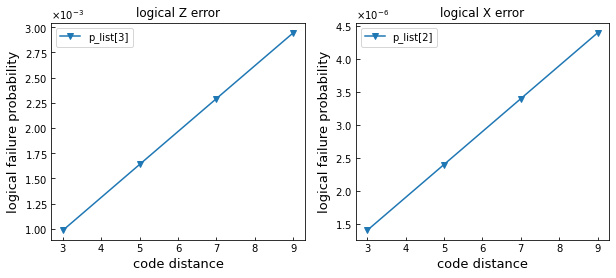

In [186]:
import matplotlib.ticker as ptick

fig, axes = plt.subplots(1,2,figsize=(10,4))
code_distance_list = [3,5,7,9]
p = 0.0001
eta= 1000
a = []
b= []
for i in range(len(code_distance_list)):
    a.append(pg_z(p,eta,code_distance_list[i]))
    b.append((5*code_distance_list[i]-1)*p/(eta+1))
axes[0].plot(code_distance_list, np.array(a),marker='v',label='p_list[3]')
axes[0].set_xlabel("code distance", fontsize=13)
axes[0].set_ylabel("logical failure probability", fontsize=13)
#ax.set_ylim(10**(-3))
#ax.set_xlim(10**(-10))
axes[0].set_title("logical Z error")
axes[0].yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
axes[0].ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#axes[0].set_yscale("log")
axes[0].legend()

axes[1].plot(code_distance_list, np.array(b),marker='v',label='p_list[2]')
axes[1].set_xlabel("code distance", fontsize=13)
axes[1].set_ylabel("logical failure probability", fontsize=13)
#axes[1].set_ylim(10**(-3))
#axes[1].set_xlim(10**(-10))
axes[1].set_title("logical X error")
axes[1].yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
axes[1].ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#axes[1].set_yscale("log")
axes[1].legend()

plt.show()

### 反復符号

### 符号距離依存性

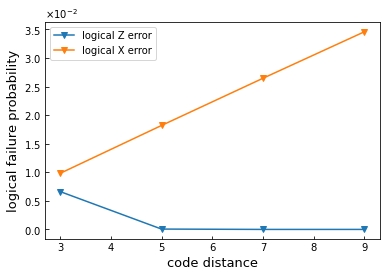

[0.006627986900153704, 6.0177232406088965e-05, 5.42801064817855e-07, 4.895528427084628e-09]
[0.009810211512298132, 0.018197110730824497, 0.026460540562659753, 0.03460245847638146]


In [195]:
plt.rcParams["xtick.direction"] = "in"     
plt.rcParams["ytick.direction"] = "in" 
fig, ax = plt.subplots()
code_distance_list = [3,5,7,9]
p = 0.0001
eta= 1000
round_rep = 10000
a = []
b = []
c = []
for i in range(len(code_distance_list)):
    a.append(pL_z(p,code_distance_list[i],round_rep))
    b.append(1/2 * (1- (1 - 2 * (4*code_distance_list[i]-3)*p/(eta+1))**round_rep) + 3*code_distance_list[i]*p*(2*eta+1)/(2*eta+2))
    c.append(pg_z(p,eta,code_distance_list[i]))
ax.plot(code_distance_list, np.array(a),marker='v',label="logical Z error")
ax.plot(code_distance_list, np.array(b),marker='v',label="logical X error")
#ax.plot(code_distance_list, np.array(c),marker='v',label="logical gate(Z)")
ax.set_xlabel("code distance", fontsize=13)
ax.set_ylabel("logical failure probability", fontsize=13)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#ax.set_ylim(10**(-3))
#ax.set_xlim(10**(-10))
#ax.set_yscale("log")
#ax.grid()
plt.legend()
plt.show()

print(a)
print(b)

### ラウンド依存性

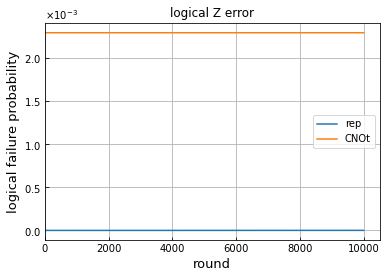

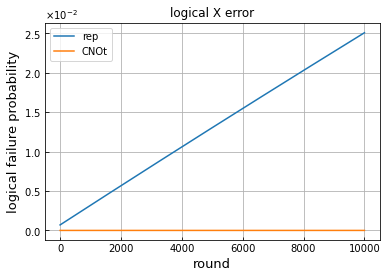

In [193]:
plt.rcParams["xtick.direction"] = "in"     
plt.rcParams["ytick.direction"] = "in" 

round_list = np.arange(0, 10001, 1)
p = 0.0001
eta= 1000
code_distance = 7

a = []
b = []
fig, ax = plt.subplots()
for i in range(len(round_list)):
    a.append(pL_z(p,code_distance,round_list[i]))
    b.append(pg_z(p,eta,code_distance))
ax.plot(round_list, np.array(a),marker='',label="rep")
ax.plot(round_list, np.array(b),marker='',label="CNOt")
ax.set_xlabel("round", fontsize=13)
ax.set_ylabel("logical failure probability", fontsize=13)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_title("logical Z error")
ax.grid()
ax.legend()
#ax.set_ylim(10**(-3))
ax.set_xlim(0,)

c = []
d = []
fig, ax = plt.subplots()
for i in range(len(round_list)):
    c.append(pL_X(p,code_distance,round_list[i],eta))
    d.append((5*code_distance-1)*p/(eta+1))
ax.plot(round_list, np.array(c),marker='',label="rep")
ax.plot(round_list, np.array(d),marker='',label="CNOt")
ax.set_xlabel("round", fontsize=13)
ax.set_ylabel("logical failure probability", fontsize=13)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_title("logical X error")

ax.grid()
plt.legend()
plt.show()

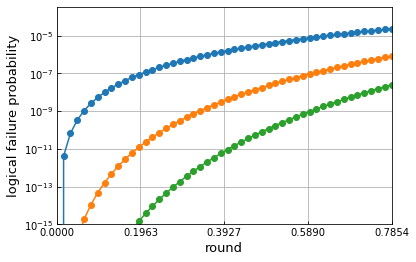

In [58]:
plt.rcParams["xtick.direction"] = "in"     
plt.rcParams["ytick.direction"] = "in" 
fig, ax = plt.subplots()
d_list = [3,5,7]
a = np.linspace(0, np.pi/4, 50)
for i in range(3):
    b = d_list[i]/3 * 10**(-3) * np.sin(a/2)**(2*(d_list[i]-1)) / np.cos(a/2)
    ax.plot(a, b,marker='o')
ax.set_xlabel("round", fontsize=13)
ax.set_ylabel("logical failure probability", fontsize=13)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_xticks([0, np.pi/16, np.pi/8, np.pi*3/16, np.pi/4])
#ax.set_xticklabels([0, np.pi/16, np.pi/8, np.pi*3/16, np.pi/4])
ax.set_yscale("log")
ax.set_xlim(0, np.pi/4)
ax.set_ylim(10**(-15))
#ax.set_xlim(10**(-10))

ax.grid()
plt.show()

In [59]:
print(str(round_list))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
